# Clickbait calssification with and without emotions

## Install dependencies and imports

In [1]:
! pip install datasets transformers sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.2/486.2 kB 19.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 76.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 83.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 30.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 19.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 86.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 52.0 MB/s eta 0:00:00


In [2]:
!pip install --upgrade accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.6/227.6 kB 16.7 MB/s eta 0:00:00


In [3]:
!pip install evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 5.4 MB/s eta 0:00:00


In [4]:
!pip install Keras-Preprocessing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 5.4 MB/s eta 0:00:00


In [5]:
import evaluate
import gensim
import seaborn as sns
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import precision_score, f1_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, pipeline
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, GlobalMaxPooling1D
from mlxtend.plotting import plot_confusion_matrix
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

## Data Import

In [6]:
#mount drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
#read clickbait data without emotions
ClickBaitdatasetWithoutEm = pd.read_csv('/content/drive/MyDrive/nlp/project/clickbait_data.csv')
ClickBaitdatasetWithoutEm

,headline,clickbait
0,Should I Get Bings,1
1,Which TV Female Friend Group Do You Belong In,1
2,"The New ""Star Wars: The Force Awakens"" Trailer...",1
3,"This Vine Of New York On ""Celebrity Big Brothe...",1
4,A Couple Did A Stunning Photo Shoot With Their...,1
...,...,...
31995,"To Make Female Hearts Flutter in Iraq, Throw a...",0
31996,"British Liberal Democrat Patsy Calton, 56, die...",0
31997,Drone smartphone app to help heart attack vict...,0
31998,"Netanyahu Urges Pope Benedict, in Israel, to D...",0


In [8]:
#read clickbait data with emotions
ClickBaitdatasetWithEm = pd.read_csv('/content/drive/MyDrive/nlp/project/clickBaitDatasetWithE.csv')
ClickBaitdatasetWithEm = ClickBaitdatasetWithEm.drop(columns=['Unnamed: 0'])
ClickBaitdatasetWithEm

,headline,clickbait,emotions
0,Should I Get Bings,1,neutral
1,Which TV Female Friend Group Do You Belong In,1,curiosity
2,"The New ""Star Wars: The Force Awakens"" Trailer...",1,excitement
3,"This Vine Of New York On ""Celebrity Big Brothe...",1,admiration
4,A Couple Did A Stunning Photo Shoot With Their...,1,neutral
...,...,...,...
31995,"To Make Female Hearts Flutter in Iraq, Throw a...",0,neutral
31996,"British Liberal Democrat Patsy Calton, 56, die...",0,sadness
31997,Drone smartphone app to help heart attack vict...,0,neutral
31998,"Netanyahu Urges Pope Benedict, in Israel, to D...",0,neutral


## EDA


**Checking for data structure**

In [9]:
ClickBaitdatasetWithoutEm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32000 entries, 0 to 31999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   headline   32000 non-null  object
 1   clickbait  32000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 500.1+ KB


**Checking for Null/Missing values**

In [10]:
ClickBaitdatasetWithoutEm.isnull().sum()

headline     0
clickbait    0
dtype: int64

**Data Visualization**

<Axes: xlabel='clickbait', ylabel='count'>

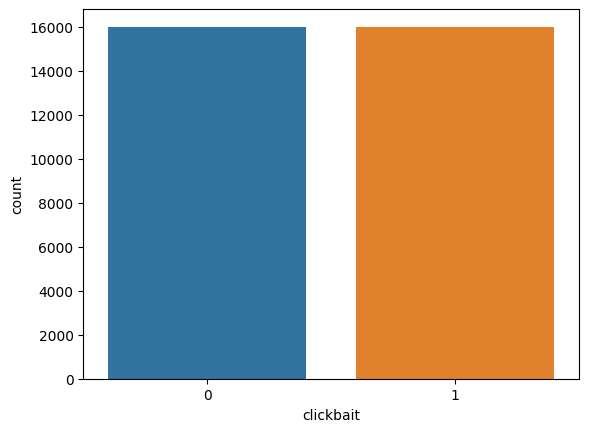

In [11]:
#clickbait distribution
sns.countplot(x=ClickBaitdatasetWithoutEm.clickbait)

**Emotion distribution for clickbait and non-clickbait headlines**

In [12]:
print('---'*15)
print('Top five emotions for clickbait headlines:')
print(ClickBaitdatasetWithEm[ClickBaitdatasetWithEm['clickbait'] == 1].emotions.value_counts().head(5))
print('---'*15)
print('Top five emotions for non-clickbait headlines:')
print(ClickBaitdatasetWithEm[ClickBaitdatasetWithEm['clickbait'] == 0].emotions.value_counts().head(5))

---------------------------------------------
Top five emotions for clickbait headlines:
neutral       11500
curiosity      1452
admiration      973
amusement       462
excitement      202
Name: emotions, dtype: int64
---------------------------------------------
Top five emotions for non-clickbait headlines:
neutral           13945
sadness            1317
disappointment      288
disapproval          61
fear                 58
Name: emotions, dtype: int64


## Clickbait Classification without emotions

### Word2Vec Embedding

In [13]:
#Separate input text from target text
X_2 = ClickBaitdatasetWithoutEm.drop('clickbait', axis=1)
y_2= ClickBaitdatasetWithoutEm.clickbait

In [14]:
X_2.head(3)

,headline
0,Should I Get Bings
1,Which TV Female Friend Group Do You Belong In
2,"The New ""Star Wars: The Force Awakens"" Trailer..."


In [15]:
# here we create a separate embeddings for each feature because we think that the headline columns have distinct meanings
def extract_featuresH(headline):
    headline_embeddings = []

    for word in headline:
        if word in word2vec_headline.wv:
            headline_embeddings.append(word2vec_headline.wv[word])

    # we calcualte the avergae of embeddings to provides a fixed-size representation , if the shape is not the same that make error in traning model.
    if headline_embeddings:
        headline_avg = np.mean(headline_embeddings, axis=0)
    else:
      #  a zero embeding of the same shape as word2vec_headline.wv.vectors[0] if there no embeding for this worid
        headline_avg = np.zeros_like(word2vec_headline.wv.vectors[0])

    return headline_avg

In [16]:
# we'll tokenize the words in the headline columns first
X_2['headline'] = X_2['headline'].apply(lambda x: word_tokenize(x))

In [17]:
X_2['headline'].head(3)

0                              [Should, I, Get, Bings]
1    [Which, TV, Female, Friend, Group, Do, You, Be...
2    [The, New, ``, Star, Wars, :, The, Force, Awak...
Name: headline, dtype: object

In [18]:
# we train separate Word2Vec models for each feature
word2vec_headline = gensim.models.Word2Vec(X_2['headline'], vector_size=100)

In [19]:
X_2['headline_embeddings'] = X_2.apply(lambda row: extract_featuresH(row['headline']), axis=1)

In [20]:
X_2.head(3)

,headline,headline_embeddings
0,"[Should, I, Get, Bings]","[-0.6460112, 0.112264685, -0.87425447, 0.03083..."
1,"[Which, TV, Female, Friend, Group, Do, You, Be...","[-0.13215645, 0.08369919, -0.5640352, 0.352360..."
2,"[The, New, ``, Star, Wars, :, The, Force, Awak...","[0.16410016, 0.050300423, -0.15896872, 0.43786..."


In [21]:
#Split the dataset to 80% training and 20% testing
X_train, X_test, y_train, y_test = train_test_split(X_2['headline_embeddings'], y_2, test_size=0.2, random_state=42)

X_train_headline = np.array(X_train.to_numpy().tolist())

X_test_headline = np.array(X_test.to_numpy().tolist())

# we don't use np.hstack because it expects a sequence of arrays as its argument, but we're passing a single array
# Stacking the embeddings in this way allows the model to process multiple headlines simultaneously during training or inference. It ensures that the model can handle the input data in a batch-wise manner, which can lead to more efficient computation and faster training.
X_train = np.vstack(X_train_headline)
X_test = np.vstack(X_test_headline)

### Logestic Regression, Naive-Bayes, Support Vector Machine

In [22]:
# Initialize and train the classifier
Classifiers = [
{
   'label': 'Logistic Regression',
   'model': LogisticRegression(C=0.00000001,solver='liblinear',max_iter=200, multi_class='auto'),
},

{
   'label': 'Naive-Byes',
   'model': MultinomialNB()
},
{
   'label': 'SVM',
   'model': SVC()
}
]


In [23]:
#fit the models
Model=[]
prediction = []
for c in Classifiers:
    try:
        classifier = c['model']
        if (c['label'] == 'Naive-Byes'):
          scaler = MinMaxScaler()
          X_train = scaler.fit_transform(X_train)
          X_test = scaler.transform(X_test)
        fit = classifier.fit(X_train, y_train)
        pred = fit.predict(X_test)
    except Exception:
        if (c['label'] == 'Naive-Byes'):
          scaler = MinMaxScaler()
          X_train_features = scaler.fit_transform(X_train)
          X_test_feature = scaler.transform(X_test)
        fit = classifier.fit(X_train, y_train)
        pred = fit.predict(X_test)
    prediction.append(pred)
    Model.append(c['label'])

In [24]:
#Save the SVM predections to use it later in calculating the p-value
svmPredections = prediction[2]

#### Model Evaluation

In [25]:
def Model_Evaluation(ytest, pred, c ):

  #Accuracy:
    acc_score = accuracy_score(ytest, pred, normalize=True)
    print(f"The accuracy score of {c} is {acc_score}")


  #Precesion:
    prec_score = precision_score(ytest, pred, average='weighted')
    print(f"The precision score of {c} is {prec_score}")

  #Recall
    recall = recall_score(ytest, pred, average='weighted')
    print(f"The recall score of {c} is {recall}")

  #F1 Score
    f1 = f1_score(ytest, pred, average='weighted')
    print(f"The F1 score of {c} is {f1}")
    print('---'*15)

In [26]:
for i,p in enumerate(prediction):
  Model_Evaluation(y_test, p, Classifiers[i]['label'])

The accuracy score of Logistic Regression is 0.89828125
The precision score of Logistic Regression is 0.9147188724512055
The recall score of Logistic Regression is 0.89828125
The F1 score of Logistic Regression is 0.8970019269098968
---------------------------------------------
The accuracy score of Naive-Byes is 0.96515625
The precision score of Naive-Byes is 0.9653896602157778
The recall score of Naive-Byes is 0.96515625
The F1 score of Naive-Byes is 0.9651607703038241
---------------------------------------------
The accuracy score of SVM is 0.980625
The precision score of SVM is 0.9806361369646263
The recall score of SVM is 0.980625
The F1 score of SVM is 0.9806258745175193
---------------------------------------------


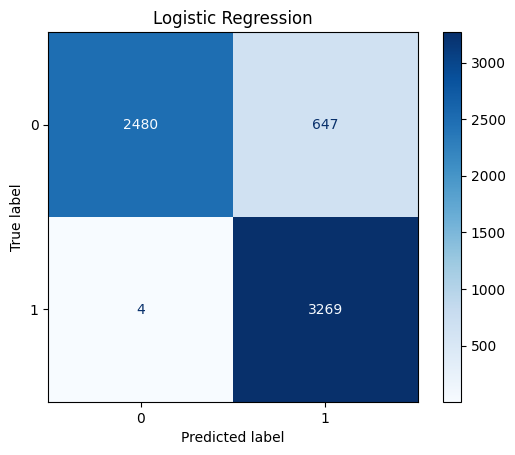

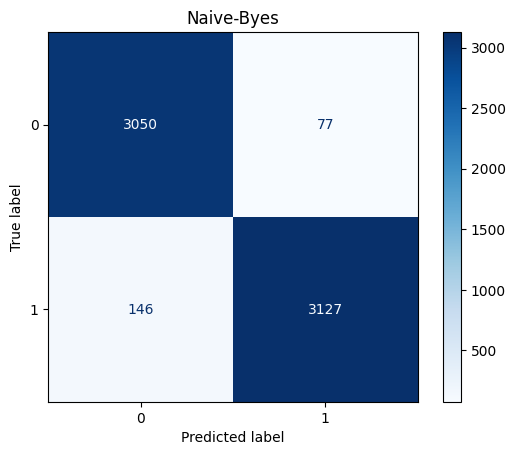

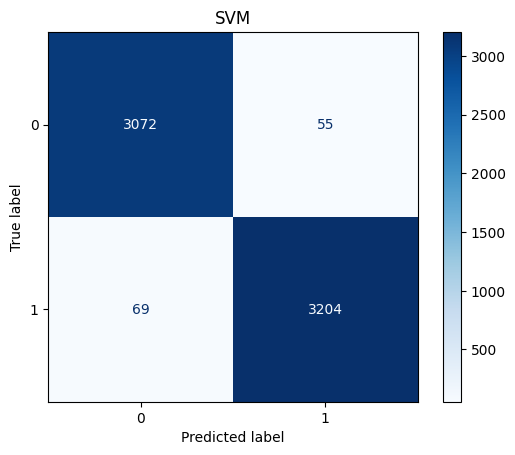

In [27]:
for i,p in enumerate(prediction):
    cm = confusion_matrix(y_test, p, labels=fit.classes_)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap=plt.cm.Blues, values_format='g')
    disp.ax_.set_title(Classifiers[i]['label'])

plt.show()

### LSTM

In [28]:
# we don't use np.hstack because it expects a sequence of arrays as its argument, but we're passing a single array
X_train = np.vstack(X_train_headline)
X_test = np.vstack(X_test_headline)

# Reshape the input data
# the shape of input data tp lstm should be (batch_size, sequence_length, num_features)
X_train_features = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_features = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Model definition
model = Sequential()
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=True))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

# Build the model
model.build(input_shape=(None, X_train_features.shape[1], 1))

model.summary()

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_features, y_train, batch_size=32, validation_data=(X_test_features, y_test), epochs=3)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 100, 1)            0         
                                                                 
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 global_max_pooling1d (Globa  (None, 50)               0         
 lMaxPooling1D)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
____________________________________________________

In [29]:
model.save('clickbaitmodelWithoutEm')

#### Model Evaluation

200/200 [==============================] - 1s 4ms/step
---------------------------------------------
Accuracy:0.95375000
Precision: 0.97540722
Recall: 0.93308891
F1 Score: 0.95377889
---------------------------------------------


([<matplotlib.axis.YTick at 0x7fb130a0ae30>,
 [Text(0, 0, 'Not clickbait'), Text(0, 1, 'Clickbait')])

<Figure size 640x480 with 0 Axes>

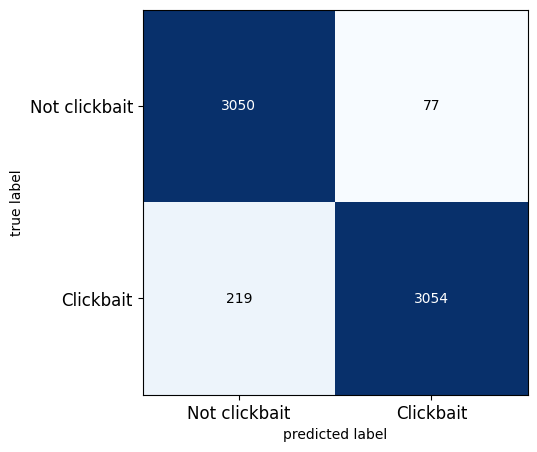

In [30]:
preds = [round(i[0]) for i in model.predict(X_test_features)]
cm = confusion_matrix(y_test, preds)
#compute metrics
precision = cm[1, 1] / (cm[1, 1] + cm[0, 1])
recall = cm[1, 1] / (cm[1, 1] + cm[1, 0])
f1 = f1_score(y_test, preds)
accuracy = (cm[1, 1] + cm[0,0]) / (cm[1, 1] + cm[0, 1]+ cm[0,0] + cm[1,0])

print('---'*15)
print('Accuracy:{:.8f}'.format(accuracy))
print("Precision: {:.8f}".format(precision))
print("Recall: {:.8f}".format(recall))
print("F1 Score: {:.8f}".format(f1))
print('---'*15)

#plot confusion matrix
plt.figure()
plot_confusion_matrix(cm, figsize=(5,5), hide_ticks=True, cmap='Blues')
plt.xticks(range(2), ['Not clickbait', 'Clickbait'], fontsize=12)
plt.yticks(range(2), ['Not clickbait', 'Clickbait'], fontsize=12)

In [31]:
lstmPreds = preds

### RoBERTa

this code was inspired from [this link](https://github.com/huggingface/workshops/blob/main/luzern-university/02-text-classification.ipynb)

#### The dataset

In [32]:
#return 'DatasetDict'
clickbait_datasets = DatasetDict({
    "train": Dataset.from_pandas(ClickBaitdatasetWithoutEm)
    })
clickbait_datasets

DatasetDict({
    train: Dataset({
        features: ['headline', 'clickbait'],
        num_rows: 32000
    })
})

In [33]:
## Split the 25% test %75 training, then 25% from training to validation
datasets_train_test = clickbait_datasets["train"].train_test_split(test_size=0.25)
datasets_train_validation = datasets_train_test["train"].train_test_split(test_size=0.25)

clickbait_datasets["train"] = datasets_train_validation["train"]
clickbait_datasets["validation"] = datasets_train_validation["test"]
clickbait_datasets["test"] = datasets_train_test["test"]

clickbait_datasets

DatasetDict({
    train: Dataset({
        features: ['headline', 'clickbait'],
        num_rows: 18000
    })
    validation: Dataset({
        features: ['headline', 'clickbait'],
        num_rows: 6000
    })
    test: Dataset({
        features: ['headline', 'clickbait'],
        num_rows: 8000
    })
})

#### Mapping the labels

During training, Transformers expects the labels to be ordered, starting from 0 to N. But in our data the labels are categorical (**clickbait**, **non-clickbait**) so we will map them to values **1** and **0** respectively.

In [34]:
#define the label mapping from ID to name
# نحول من الليبل الى ارقام
label_names = ["non_clickbait", "clickbait"]
id2label = {idx:label for idx, label in enumerate(label_names)}
id2label

{0: 'non_clickbait', 1: 'clickbait'}

We can then apply this mapping to our whole dataset by using the `Dataset.map()` method. Similar to the `Dataset.filter()` method, this one expects a function which receives examples as input, but returns a Python dictionary as output. The keys of the dictionary correspond to the columns, while the values correspond to the column entries. The following function creates two new columns:

* A `labels` column which is the numerical form of the target class (1,0)
* A `label_name` column which is the categorical form of the target class (clickbait, non-clickbait)

In [35]:
def map_labels(example):
    #onverts from categorical to numerical
    # من الداتا سيت
    label_id = example["clickbait"]
    return {"labels": label_id, "label_name": id2label[label_id]}

In [36]:
clickbait_datasets = clickbait_datasets.map(map_labels)
#view the first example after mapping
clickbait_datasets["train"][0]

Map:   0%|          | 0/18000 [00:00<?, ? examples/s]

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

{'headline': 'Being A Gay Guy: Thoughts Vs. Real Life',
 'clickbait': 1,
 'labels': 1,
 'label_name': 'clickbait'}

In [37]:
# the reverse label mapping
# label to id
label2id = {v:k for k,v in id2label.items()}

#### From text to tokens

Like other machine learning models, Transformers expect their inputs in the form of numbers (not strings) and so some form of preprocessing is required. For NLP, this preprocessing step is called tokenization. Tokenization converts strings into atomic chunks called tokens, and these tokens are subsequently encoded as numerical vectors.

In [38]:
#each pretrained model comes with its own tokenizer
model_checkpoint = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

When feeding strings to the tokenizer, two fields will be retrieved:

* `input_ids`: These correspond to the numerical encodings that map each token to an integer
* `attention_mask`: This indicates to the model which tokens should be ignored when computing self-attention

In [39]:
#apply the tokenizer to each example in our corpus
def tokenize(examples):
    return tokenizer(examples["headline"], truncation=True, max_length=180) #truncation=True will cut any inputs that are longer than 180 tokens #change max_length=180 later

In [40]:
tokenized_dataset = clickbait_datasets.map(tokenize, batched=True)
tokenized_dataset

Map:   0%|          | 0/18000 [00:00<?, ? examples/s]

Map:   0%|          | 0/6000 [00:00<?, ? examples/s]

Map:   0%|          | 0/8000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['headline', 'clickbait', 'labels', 'label_name', 'input_ids', 'attention_mask'],
        num_rows: 18000
    })
    validation: Dataset({
        features: ['headline', 'clickbait', 'labels', 'label_name', 'input_ids', 'attention_mask'],
        num_rows: 6000
    })
    test: Dataset({
        features: ['headline', 'clickbait', 'labels', 'label_name', 'input_ids', 'attention_mask'],
        num_rows: 8000
    })
})

#### Loading a pretrained model

In [41]:
#load a pretrained model from the Hub
num_labels = 2 #number of output classes
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels, label2id=label2id, id2label=id2label)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.d

#### Creating a Trainer


Initialise a `Trainer` that will take care of the training loop.


In [42]:
model_name = model_checkpoint.split("/")[-1] #
batch_size = 16
num_train_epochs = 1
logging_steps = len(tokenized_dataset["train"]) // (batch_size * num_train_epochs)

#class to define all the hyperparameters
args = TrainingArguments(
    output_dir=f"{model_name}-finetuned-clickbait-v3",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_train_epochs,
    weight_decay=0.01,# بعد كل ايبوك ايفال
    logging_steps=logging_steps,
)

In [43]:
# #function to compute metrics during evaluation -f1 score is used-
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
  acc = accuracy_score(labels, preds)
  return {
  'accuracy': acc,
  'f1': f1,
  'precision': precision,
  'recall': recall
  }

In [44]:
'''
tokenizer=tokenizer\
ensure that all of our examples are automatically padded
to the longest example in each batch. This is needed so that matrix operations
in the forward pass of the model can be computed.
'''
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train() #train the model

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss


#### Evaluating the model

In [ ]:
def evaluate_():
    # Load test data
    dataset = tokenized_dataset["test"]
    # Generate predictions and metrics
    preds = trainer.evaluate(eval_dataset=dataset)
    return {"F1": preds["eval_f1"], "Precision": preds["eval_precision"], "Recall":preds["eval_recall"], "Accuracy": preds["eval_accuracy"]}

In [ ]:
evaluate_()

### Testing clickbaits examples using the best classifier (RoBERTa)

In [ ]:
#sample clickbait from the dataset
test_sample1='The New Star Wars: The Force Awakens Trailer Is Here To Give You Chills'

#sample not a clickbait from the dataset
test_sample2 ='Scientology defector arrested after attempting to leave organization'

#made up sample, expected to be clickbait
test_sample3 ='Hurry grab our promo now!'

#test smaples from the intrnet (All are clickbaits):
test_sample4 ='You’ll Never Believe What This CEO Did to Get Ahead in Business!'
test_sample5 ='One Simple Trick to Improve Your Memory Instantly!'
test_sample6 ='Why You Should Never Trust Experts Opinion Again!'

#test smaples from the intrnet (All are Non clickbaits):
test_sample7 ='Dry July 2017: what is it and what happens when you give up alcohol'
test_sample8 ='What happens when a child has dementia'
test_sample9 ='What Happens When a Kid Is Charged With a Felony Murder?'


In [ ]:
finetuned_checkpoint = "/content/drive/MyDrive/xlm-roberta-base-finetuned-clickbait-v3/checkpoint-1125"
classifier = pipeline("text-classification", model=finetuned_checkpoint)

In [ ]:
print(classifier(test_sample1))
print(classifier(test_sample2))
print(classifier(test_sample3))
print(classifier(test_sample4))
print(classifier(test_sample5))
print(classifier(test_sample6))
print(classifier(test_sample7))
print(classifier(test_sample8))
print(classifier(test_sample9))

## Clickbait Classification with emotions


### Word2Vec Embedding

In [ ]:
# Define the features (X) and label (Y)
X = ClickBaitdatasetWithEm.drop('clickbait', axis=1)
y = ClickBaitdatasetWithEm.clickbait

In [ ]:
X.head(3)

In [ ]:
# here we create a separate embeddings for each feature because we think that the headline and emotions columns have distinct meanings
def extract_features(headline, emotions):
    headline_embeddings = []
    emotions_embeddings = []

    for word in headline:
        if word in word2vec_headline.wv:
            headline_embeddings.append(word2vec_headline.wv[word])

    for word in emotions:
        if word in word2vec_emotions.wv:
            emotions_embeddings.append(word2vec_emotions.wv[word])
    # we calcualte the avergae of embeddings to provides a fixed-size representation , if the shape is not the same that make error in traning model.
    if headline_embeddings:
        headline_avg = np.mean(headline_embeddings, axis=0)
    else:
      #  a zero embeding of the same shape as word2vec_headline.wv.vectors[0] if there no embeding for this worid
        headline_avg = np.zeros_like(word2vec_headline.wv.vectors[0])

    if emotions_embeddings:
        emotions_avg = np.mean(emotions_embeddings, axis=0)
    else:
        emotions_avg = np.zeros_like(word2vec_emotions.wv.vectors[0])

    return headline_avg, emotions_avg


In [ ]:
# we'll tokenize the words in the headline and emotions columns first
X['headline'] = X['headline'].apply(lambda x: word_tokenize(x))
X['emotions'] = X['emotions'].apply(lambda x: word_tokenize(x))

In [ ]:
# we train separate Word2Vec models for each feature
word2vec_headline = gensim.models.Word2Vec(X['headline'], vector_size=100)
word2vec_emotions = gensim.models.Word2Vec(X['emotions'], vector_size=100)

In [ ]:
X['headline_embeddings'], X['emotion_embeddings'] = zip(*X.apply(lambda row: extract_features(row['headline'], row['emotions']), axis=1))

In [ ]:
X.head(3)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X[['headline_embeddings', 'emotion_embeddings']], y, test_size=0.2, random_state=42)
# we need to convert sequences of lists  to numeric arrays, the model need numeric not sequences of lists
X_train_headline = np.array(X_train['headline_embeddings'].to_numpy().tolist())
X_train_emotion = np.array(X_train['emotion_embeddings'].to_numpy().tolist())

X_test_headline = np.array(X_test['headline_embeddings'].to_numpy().tolist())
X_test_emotion = np.array(X_test['emotion_embeddings'].to_numpy().tolist())

X_train_features = np.hstack((X_train_headline, X_train_emotion))
X_test_features = np.hstack((X_test_headline, X_test_emotion))

### Logistic Regression, Naive-Bayes, Support Vector Machine


In [ ]:
# Initialize and train the classifier
Classifiers = [
{
   'label': 'Logistic Regression',
   'model': LogisticRegression(C=0.00000001,solver='liblinear',max_iter=200, multi_class='auto'),
},

{
   'label': 'Naive-Byes',
   'model': MultinomialNB()
},
{
   'label': 'SVM',
   'model': SVC()
}
]

In [ ]:
#fit the models
Model=[]
prediction = []
for c in Classifiers:
    try:
        classifier = c['model']
        if (c['label'] == 'Naive-Byes'):
          scaler = MinMaxScaler()
          X_train_features = scaler.fit_transform(X_train_features)
          X_test_features = scaler.transform(X_test_features)
        fit = classifier.fit(X_train_features, y_train)
        pred = fit.predict(X_test_features)
    except Exception:
        if (c['label'] == 'Naive-Byes'):
          scaler = MinMaxScaler()
          X_train_features = scaler.fit_transform(X_train_features)
          X_test_feature = scaler.transform(X_test_features)
        fit = classifier.fit(X_train_features, y_train)
        pred = fit.predict(X_test_features)
    prediction.append(pred)
    Model.append(c['label'])

In [ ]:
svmPredictionWithE = prediction[2]

#### Model Evaluation

In [ ]:
for i,p in enumerate(prediction):
  Model_Evaluation(y_test, p, Classifiers[i]['label'])

In [ ]:
for i,p in enumerate(prediction):
    cm = confusion_matrix(y_test, p, labels=fit.classes_)
    disp = ConfusionMatrixDisplay(cm)
    disp.plot(cmap=plt.cm.Blues, values_format='g')
    disp.ax_.set_title(Classifiers[i]['label'])

plt.show()

### LSTM

In [ ]:
X_train_features = np.hstack((X_train_headline, X_train_emotion))
X_test_features = np.hstack((X_test_headline, X_test_emotion))

# Reshape the input data
# the shape of input data tp lstm should be (batch_size, sequence_length, num_features)
X_train_features = X_train_features.reshape(X_train_features.shape[0], X_train_features.shape[1], 1)
X_test_features = X_test_features.reshape(X_test_features.shape[0], X_test_features.shape[1], 1)

# Model definition
model = Sequential() # This line initializes a sequential model, which allows you to stack layers one after another.
model.add(Dropout(0.2)) # 20% of node will be dropout to prevent overfitiong
model.add(LSTM(50, return_sequences=True)) # The LSTM layer is configured with 50 units, which determines the dimensionality of the output space
model.add(GlobalMaxPooling1D()) # Global max pooling reduces the dimensionality of the input by taking the maximum value across the entire sequence
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
# The model architecture consists of dropout layers for regularization, an LSTM layer to model sequential data, a global max pooling layer for dimensionality reduction, and a dense layer for classification.

# Build the model
# During training or inference, you can provide a batch of sequences with different lengths, and the model will automatically adjust to handle them. The use of None allows for dynamic batching, making the model more adaptable to different input sizes.
model.build(input_shape=(None, X_train_features.shape[1], 1))

model.summary()

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_features, y_train, batch_size=32, validation_data=(X_test_features, y_test), epochs=3)

In [ ]:
model.save('clickbaitmodelWithEm')

#### Model Evaluation

In [ ]:
preds = [round(i[0]) for i in model.predict(X_test_features)]
cm = confusion_matrix(y_test, preds)
#compute metrics
precision = cm[1, 1] / (cm[1, 1] + cm[0, 1])
recall = cm[1, 1] / (cm[1, 1] + cm[1, 0])
f1 = f1_score(y_test, preds)
accuracy = (cm[1, 1] + cm[0,0]) / (cm[1, 1] + cm[0, 1]+ cm[0,0] + cm[1,0])

print('---'*15)
print('Accuracy:{:.8f}'.format(accuracy))
print("Precision: {:.8f}".format(precision))
print("Recall: {:.8f}".format(recall))
print("F1 Score: {:.8f}".format(f1))
print('---'*15)

#plot confusion matrix
plt.figure()
plot_confusion_matrix(cm, figsize=(5,5), hide_ticks=True, cmap='Blues')
plt.xticks(range(2), ['Not clickbait', 'Clickbait'], fontsize=12)
plt.yticks(range(2), ['Not clickbait', 'Clickbait'], fontsize=12)

In [ ]:
lstmPredsWithE = preds

### RoBERTa

this code was inspired from [this link](https://github.com/huggingface/workshops/blob/main/luzern-university/02-text-classification.ipynb)

#### The dataset

In [ ]:
#return 'DatasetDict'
clickbait_datasets = DatasetDict({
    "train": Dataset.from_pandas(ClickBaitdatasetWithEm)
    })
clickbait_datasets

In [ ]:
## Split the 25% test %75 training, then 25% from training to validation
datasets_train_test = clickbait_datasets["train"].train_test_split(test_size=0.25)
datasets_train_validation = datasets_train_test["train"].train_test_split(test_size=0.25)

clickbait_datasets["train"] = datasets_train_validation["train"]
clickbait_datasets["validation"] = datasets_train_validation["test"]
clickbait_datasets["test"] = datasets_train_test["test"]

clickbait_datasets

#### Mapping the labels

In [ ]:
clickbait_datasets = clickbait_datasets.map(map_labels)
#view the first example after mapping
clickbait_datasets["train"][0]

#### From text to tokens

In [ ]:
#apply the tokenizer to each example in our corpus
def tokenize(examples):
    return tokenizer(examples["headline"], examples["emotions"],truncation=True, max_length=180) #truncation=True will cut any inputs that are longer than 180 tokens #change max_length=180 later

In [ ]:
tokenized_dataset = clickbait_datasets.map(tokenize, batched=True)
tokenized_dataset

In [ ]:
#decode the input IDs to see the mapping explicitly
for token in tokenized_dataset["validation"]["input_ids"][2]:
    print(token, tokenizer.decode([token]))

#### Loading a pretrained model

In [ ]:
#load a pretrained model from the Hub
num_labels = 2 #number of output classes
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels, label2id=label2id, id2label=id2label)

#### Creating a Trainer


Initialise a `Trainer` that will take care of the training loop.


In [ ]:
model_name = model_checkpoint.split("/")[-1]
batch_size = 16
num_train_epochs = 1
logging_steps = len(tokenized_dataset["train"]) // (batch_size * num_train_epochs)

#class to define all the hyperparameters
args = TrainingArguments(
    output_dir=f"{model_name}-finetuned-clickbait-emotions-v2",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=num_train_epochs,
    weight_decay=0.01,
    logging_steps=logging_steps,
)

In [ ]:
'''
tokenizer=tokenizer\
ensure that all of our examples are automatically padded
to the longest example in each batch. This is needed so that matrix operations
in the forward pass of the model can be computed.
'''
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [ ]:
trainer.train() #train the model

#### Evaluating the model

In [ ]:
def evaluate_():
    # Load test data
    dataset = tokenized_dataset["test"]
    # Generate predictions and metrics
    preds = trainer.evaluate(eval_dataset=dataset)
    return {"F1": preds["eval_f1"], "Precision": preds["eval_precision"], "Recall":preds["eval_recall"], "Accuracy": preds["eval_accuracy"]}

In [ ]:
evaluate_()

### Testing clickbaits examples using the best classifier (RoBERTa)

In [ ]:
finetuned_checkpoint = "/content/drive/MyDrive/xlm-roberta-base-finetuned-clickbait-v3/checkpoint-1125"
classifier = pipeline("text-classification", model=finetuned_checkpoint)

In [ ]:
print(classifier(test_sample1))
print(classifier(test_sample2))
print(classifier(test_sample3))
print(classifier(test_sample4))
print(classifier(test_sample5))
print(classifier(test_sample6))
print(classifier(test_sample7))
print(classifier(test_sample8))
print(classifier(test_sample9))

#P-Value

In [ ]:
def permutation_sample(data1, data2):
    """Generate a permutation sample from two data sets."""
     # Permute the data: Randomly shuffle or permute the values or labels of the observations
    # Concatenate the data sets: data
    data = np.concatenate((data1, data2))
    # print(data)

    # Permute the concatenated array: permuted_data
    permuted_data = np.random.permutation(data)

    # Split the permuted array into two: perm_sample_1, perm_sample_2
    perm_sample_1 = permuted_data[:len(data1)]
    perm_sample_2 = permuted_data[len(data1):]

    return perm_sample_1, perm_sample_2

In [ ]:
def draw_perm_reps(data_1, data_2, func, size=1):
    """Generate multiple permutation replicates."""


    # Initialize array of replicates: perm_replicates
    perm_replicates = np.empty(size)

    for i in range(size):
        # Generate permutation sample
        perm_sample_1, perm_sample_2 = permutation_sample(data_1, data_2)
         #n each replicate, it computes a specific test statistic (func).
        # Compute the test statistics
        perm_replicates[i] = func(perm_sample_1, perm_sample_2)

    return perm_replicates

In [ ]:
def diff_of_means(data_1, data_2):
    """Difference in means of two arrays."""

    # The difference of means of data_1, data_2: diff
    diff = np.mean(data_1) -  np.mean(data_2)

    return diff

In [ ]:
# Compute difference of mean impact force from experiment: empirical_diff_means
empirical_diff_means = diff_of_means(svmPredections, svmPredictionWithE)

# Draw 10,000 permutation replicates: perm_replicates
perm_replicates = draw_perm_reps(svmPredections, svmPredictionWithE, diff_of_means, size=10000)

# Compute p-value: p
p = np.sum(perm_replicates >= empirical_diff_means) / len(perm_replicates)

# Print the result
print('p-value =', p)